<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM_GRU/LSTM_GRU_EURCHF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 7.51 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sun Jul 18 16:44:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'EURCHF'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM_GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 3.8MB/s 
     |████████████████████████████████| 174kB 52.5MB/s 
     |████████████████████████████████| 102kB 13.2MB/s 
     |████████████████████████████████| 143kB 55.9MB/s 
     |████████████████████████████████| 143kB 62.2MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(LSTM(units=64, activation=config.activation, return_sequences=True, input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(GRU(units=64, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 3
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: mdlv8zed
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM_GRU/sweeps/mdlv8zed


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: pph8yrdj with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
8/8 [==============================] - 26s 284ms/step - loss: 0.2698 - mean_squared_error: 0.2698 - mean_absolute_error: 0.4724 - val_loss: 0.0947 - val_mean_squared_error: 0.0947 - val_mean_absolute_error: 0.2402
Epoch 2/50
8/8 [==============================] - 1s 117ms/step - loss: 0.0910 - mean_squared_error: 0.0910 - mean_absolute_error: 0.2483 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1293
Epoch 3/50
8/8 [==============================] - 1s 101ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0769 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1080
Epoch 4/50
8/8 [==============================] - 1s 118ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0631 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0907
Epoch 5/50
8/8 [==============================] - 1s 112ms/step - loss: 0.0065 - mean_squared_error: 0.

epoch,49
loss,0.00383
mean_squared_error,0.00383
mean_absolute_error,0.03974
val_loss,0.00542
val_mean_squared_error,0.00542
val_mean_absolute_error,0.05884
_runtime,79
_timestamp,1626626848
_step,49
best_val_loss,0.00542


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ymxtvnu8 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 8s 69ms/step - loss: 0.1150 - mean_squared_error: 0.1150 - mean_absolute_error: 0.2255 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1285
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0963 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0650
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0640 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0663
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0459 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0584
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0030 - mean_squared_

epoch,66
loss,0.00179
mean_squared_error,0.00179
mean_absolute_error,0.02626
val_loss,0.00255
val_mean_squared_error,0.00255
val_mean_absolute_error,0.0386
_runtime,24
_timestamp,1626626890
_step,66
best_val_loss,0.00236


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▃▄▂▂▂▂▃▁▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▂▁▂▁▁▁▁▁▂▁▁▁
val_loss,█▃▂▄▂▂▂▃▂▂▂▁▂▁▁▁▂▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,█▃▂▄▂▂▂▃▂▂▂▁▂▁▁▁▂▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▃▃▅▃▂▂▃▂▂▂▂▂▂▁▂▃▂▂▁▁▂▂▂▁▃▁▁▁▂▁▁▁▁▁▂▂▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jho7y5p2 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 4s 35ms/step - loss: 0.0861 - mean_squared_error: 0.0861 - mean_absolute_error: 0.1942 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0576
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0399 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0508
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0339 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0516
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0350 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0532
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.

epoch,49
loss,0.0014
mean_squared_error,0.0014
mean_absolute_error,0.02087
val_loss,0.00222
val_mean_squared_error,0.00222
val_mean_absolute_error,0.03599
_runtime,38
_timestamp,1626626935
_step,49
best_val_loss,0.00219


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▇▆▄▄▅▃▃▃▃▃▂▂▂▂▂▁▁▂▅▁▂▂▁▂▂▂▂▂▂▃▁▁▁▁▁▂▁▁
val_mean_squared_error,█▆▇▆▄▄▅▃▃▃▃▃▂▂▂▂▂▁▁▂▅▁▂▂▁▂▂▂▂▂▂▃▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▆▆▇▄▄▅▄▄▄▃▃▂▂▂▂▂▂▂▂▆▁▂▂▁▂▂▂▃▂▂▄▂▁▁▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wabbprd9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 8s 144ms/step - loss: 0.1148 - mean_squared_error: 0.1148 - mean_absolute_error: 0.2634 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1013
Epoch 2/100
32/32 [==============================] - 4s 115ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0532 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0902
Epoch 3/100
32/32 [==============================] - 4s 111ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0492 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0842
Epoch 4/100
32/32 [==============================] - 4s 113ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0513 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0779
Epoch 5/100
32/32 [==============================] - 4s 113ms/step - loss: 0.0044 - mean_squ

epoch,31
loss,0.00294
mean_squared_error,0.00294
mean_absolute_error,0.03497
val_loss,0.00621
val_mean_squared_error,0.00621
val_mean_absolute_error,0.06431
_runtime,128
_timestamp,1626627100
_step,31
best_val_loss,0.00534


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▃▃▂▂▃▂▃▂▂▁▂▁▂▂▁▁▁▁▁▁▂▁▁▂▁▁▂
val_mean_squared_error,█▆▅▅▄▃▃▂▂▃▂▃▂▂▁▂▁▂▂▁▁▁▁▁▁▂▁▁▂▁▁▂
val_mean_absolute_error,█▆▅▄▄▃▂▂▂▃▂▃▂▂▂▂▁▂▂▁▁▁▁▁▂▂▁▂▂▂▁▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bftzkxfn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 5s 48ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - mean_absolute_error: 0.1722 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0821
Epoch 2/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0446 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0683
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0380 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0640
Epoch 4/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0378 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0641
Epoch 5/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0053 - mean_squared_erro

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,96
loss,0.00153
mean_squared_error,0.00153
mean_absolute_error,0.02218
val_loss,0.00241
val_mean_squared_error,0.00241
val_mean_absolute_error,0.03817
_runtime,36
_timestamp,1626627154
_step,96
best_val_loss,0.00229


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pc3rd6ag with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 4s 131ms/step - loss: 0.1242 - mean_squared_error: 0.1242 - mean_absolute_error: 0.2454 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0979
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0165 - mean_squared_error: 0.0165 - mean_absolute_error: 0.0865 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0937
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0641 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0921
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0564 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0908
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0120 - mean_squared_error: 0.012

epoch,36
loss,0.00505
mean_squared_error,0.00505
mean_absolute_error,0.04961
val_loss,0.00464
val_mean_squared_error,0.00464
val_mean_absolute_error,0.05389
_runtime,11
_timestamp,1626627202
_step,36
best_val_loss,0.00455


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▂▃▂▂▂▃▂▂▂▂▃▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▁▂▁▂
val_loss,███▇▆▄▆▄▆▃▅▆▃▅▂▆▂▂▃▂▅▃▁▁▂▂▁▁▂▂▁▂▂▁▁▁▁
val_mean_squared_error,███▇▆▄▆▄▆▃▅▆▃▅▂▆▂▂▃▂▅▃▁▁▂▂▁▁▂▂▁▂▂▁▁▁▁
val_mean_absolute_error,█▇▇▇▆▅▆▄▅▃▄▆▃▅▃▆▃▃▄▂▅▃▁▁▂▂▁▁▂▂▁▂▂▁▁▂▂
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆██████████
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆██████████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zl1t1rub with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 4s 67ms/step - loss: 0.0934 - mean_squared_error: 0.0934 - mean_absolute_error: 0.2340 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1027
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0924 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0740
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0512 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0551
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0381 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0540
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_erro

epoch,61
loss,0.00177
mean_squared_error,0.00177
mean_absolute_error,0.0239
val_loss,0.00249
val_mean_squared_error,0.00249
val_mean_absolute_error,0.03861
_runtime,20
_timestamp,1626627243
_step,61
best_val_loss,0.00242


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: e85nqnjx with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 5s 72ms/step - loss: 0.1744 - mean_squared_error: 0.1744 - mean_absolute_error: 0.3365 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1022
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0919 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1163
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0752 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0866
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0546 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0777
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0047 - mean_squared_

epoch,99
loss,0.00195
mean_squared_error,0.00195
mean_absolute_error,0.02671
val_loss,0.00303
val_mean_squared_error,0.00303
val_mean_absolute_error,0.04159
_runtime,28
_timestamp,1626627278
_step,99
best_val_loss,0.00293


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 31gz2stc with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 5s 133ms/step - loss: 0.2191 - mean_squared_error: 0.2191 - mean_absolute_error: 0.4011 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1199
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0750 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1053
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0642 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0957
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0520 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0910
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0076 - mean_squared_error: 0.0076 

epoch,49
loss,0.0035
mean_squared_error,0.0035
mean_absolute_error,0.03769
val_loss,0.0055
val_mean_squared_error,0.0055
val_mean_absolute_error,0.05419
_runtime,15
_timestamp,1626627303
_step,49
best_val_loss,0.00485


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lda314s1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 7s 192ms/step - loss: 764.1226 - mean_squared_error: 764.1226 - mean_absolute_error: 7.8142 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1181
Epoch 2/100
16/16 [==============================] - 2s 128ms/step - loss: 0.0389 - mean_squared_error: 0.0389 - mean_absolute_error: 0.1549 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0963
Epoch 3/100
16/16 [==============================] - 2s 122ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - mean_absolute_error: 0.1415 - val_loss: 0.1121 - val_mean_squared_error: 0.1121 - val_mean_absolute_error: 0.3156
Epoch 4/100
16/16 [==============================] - 2s 119ms/step - loss: 0.0678 - mean_squared_error: 0.0678 - mean_absolute_error: 0.2139 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1294
Epoch 5/100
16/16 [==============================] - 2s 116ms/step - loss: 0.0618 - mean

epoch,48
loss,0.0032
mean_squared_error,0.0032
mean_absolute_error,0.03985
val_loss,0.00633
val_mean_squared_error,0.00633
val_mean_absolute_error,0.06464
_runtime,104
_timestamp,1626627416
_step,48
best_val_loss,0.00243


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂█▂▂▃▃▂▁▃▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▂▂█▂▂▃▃▂▁▃▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▂█▃▂▄▄▂▂▄▃▂▃▃▂▃▃▁▁▂▂▂▁▁▁▁▂▁▁▂▂▁▁▁▁▂▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zzzaicjl with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 6s 258ms/step - loss: 2.3120 - mean_squared_error: 2.3120 - mean_absolute_error: 1.2156 - val_loss: 0.0394 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1670
Epoch 2/50
8/8 [==============================] - 1s 123ms/step - loss: 0.0365 - mean_squared_error: 0.0365 - mean_absolute_error: 0.1515 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1303
Epoch 3/50
8/8 [==============================] - 1s 120ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - mean_absolute_error: 0.1145 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1085
Epoch 4/50
8/8 [==============================] - 1s 116ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - mean_absolute_error: 0.1141 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1209
Epoch 5/50
8/8 [==============================] - 1s 121ms/step - loss: 0.0290 - mean_squared_error: 0.0

epoch,31
loss,0.00603
mean_squared_error,0.00603
mean_absolute_error,0.05839
val_loss,0.00751
val_mean_squared_error,0.00751
val_mean_absolute_error,0.06824
_runtime,40
_timestamp,1626627521
_step,31
best_val_loss,0.00392


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▂▂▂▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▅▄█▂▄▄▃▂▄▅▂█▆▃▃▁▇▂▁▂▂▂▂▁▃▁▃▁▂
val_mean_squared_error,█▅▄▅▄█▂▄▄▃▂▄▅▂█▆▃▃▁▇▂▁▂▂▂▂▁▃▁▃▁▂
val_mean_absolute_error,█▆▅▅▅█▃▅▄▃▂▅▅▃▇▆▄▃▁▆▂▁▃▂▂▃▁▃▁▄▁▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: jk8q5jpm with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 6s 278ms/step - loss: 0.2201 - mean_squared_error: 0.2201 - mean_absolute_error: 0.4016 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1372
Epoch 2/100
8/8 [==============================] - 1s 130ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0809 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1210
Epoch 3/100
8/8 [==============================] - 1s 130ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0700 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1100
Epoch 4/100
8/8 [==============================] - 1s 133ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0784 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0945
Epoch 5/100
8/8 [==============================] - 1s 125ms/step - loss: 0.0098 - mean_squared_error

epoch,71
loss,0.00323
mean_squared_error,0.00323
mean_absolute_error,0.03713
val_loss,0.00858
val_mean_squared_error,0.00858
val_mean_absolute_error,0.0743
_runtime,81
_timestamp,1626627622
_step,71
best_val_loss,0.00552


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▂▅▂▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂
val_mean_squared_error,█▆▄▄▃▂▅▂▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▇▄▄▃▂▅▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▃▂▁▂▁▁▁▂▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: y8i6r2bc with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 9s 146ms/step - loss: 0.1965 - mean_squared_error: 0.1965 - mean_absolute_error: 0.3646 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1099
Epoch 2/100
32/32 [==============================] - 4s 116ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0700 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1020
Epoch 3/100
32/32 [==============================] - 4s 123ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0590 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0875
Epoch 4/100
32/32 [==============================] - 4s 118ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0586 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0795
Epoch 5/100
32/32 [==============================] - 4s 127ms/step - loss: 0.0068 - mean_squ

epoch,87
loss,0.00245
mean_squared_error,0.00245
mean_absolute_error,0.03058
val_loss,0.00435
val_mean_squared_error,0.00435
val_mean_absolute_error,0.05257
_runtime,353
_timestamp,1626627991
_step,87
best_val_loss,0.00399


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▃▂▁▂▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: aj32s34n with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 142ms/step - loss: 0.1255 - mean_squared_error: 0.1255 - mean_absolute_error: 0.2497 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1017
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0878 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1007
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0876 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0711
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0545 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.1024
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0135 - mean_squared_error: 0.

epoch,69
loss,0.00243
mean_squared_error,0.00243
mean_absolute_error,0.03172
val_loss,0.00467
val_mean_squared_error,0.00467
val_mean_absolute_error,0.05574
_runtime,18
_timestamp,1626628053
_step,69
best_val_loss,0.00278


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▃▂▃▂▃▂▂▂▂▂▂▂▁▁▃▁▂▁▁▂▁▂▁▂▁▂▂▁▁▁▂▁▁▁▁
val_loss,███▅▆▃▄▃▃▃▂▂▅▂▃▃▂▂▁▄▁▁▂▁▁▁▁▁▂▁▃▁▁▁▁▂▁▁▁▂
val_mean_squared_error,███▅▆▃▄▃▃▃▂▂▅▂▃▃▂▂▁▄▁▁▂▁▁▁▁▁▂▁▃▁▁▁▁▂▁▁▁▂
val_mean_absolute_error,███▆▆▃▄▃▃▃▂▂▅▂▄▃▂▂▂▅▁▂▂▂▂▁▁▁▂▁▄▁▁▁▁▂▁▁▂▃
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: reg2w68n with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 7s 195ms/step - loss: 0.0878 - mean_squared_error: 0.0878 - mean_absolute_error: 0.2255 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1328
Epoch 2/100
16/16 [==============================] - 2s 131ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0887 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0832
Epoch 3/100
16/16 [==============================] - 2s 128ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0647 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0744
Epoch 4/100
16/16 [==============================] - 2s 128ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0613 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0711
Epoch 5/100
16/16 [==============================] - 2s 124ms/step - loss: 0.0071 - mean_squ

epoch,99
loss,0.00191
mean_squared_error,0.00191
mean_absolute_error,0.0263
val_loss,0.00296
val_mean_squared_error,0.00296
val_mean_absolute_error,0.04321
_runtime,212
_timestamp,1626628274
_step,99
best_val_loss,0.00276


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: beq6w2tr with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 5s 137ms/step - loss: 0.2483 - mean_squared_error: 0.2483 - mean_absolute_error: 0.4131 - val_loss: 0.0221 - val_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.1245
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0776 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1137
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0656 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1136
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0595 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0991
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0108 - mean_squared_error: 0.0

epoch,99
loss,0.00279
mean_squared_error,0.00279
mean_absolute_error,0.03338
val_loss,0.00363
val_mean_squared_error,0.00363
val_mean_absolute_error,0.04483
_runtime,21
_timestamp,1626628362
_step,99
best_val_loss,0.00356


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▄▄▃▄▃▃▃▂▃▂▂▂▂▂▂▃▂▃▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: r8tvyb67 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 6s 187ms/step - loss: 0.2453 - mean_squared_error: 0.2453 - mean_absolute_error: 0.4356 - val_loss: 0.0592 - val_mean_squared_error: 0.0592 - val_mean_absolute_error: 0.2118
Epoch 2/50
16/16 [==============================] - 2s 119ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1415 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1207
Epoch 3/50
16/16 [==============================] - 2s 126ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0872 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0985
Epoch 4/50
16/16 [==============================] - 2s 123ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0578 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0801
Epoch 5/50
16/16 [==============================] - 2s 127ms/step - loss: 0.0046 - mean_squared_

epoch,33
loss,0.00419
mean_squared_error,0.00419
mean_absolute_error,0.03984
val_loss,0.00702
val_mean_squared_error,0.00702
val_mean_absolute_error,0.06864
_runtime,77
_timestamp,1626628449
_step,33
best_val_loss,0.00657


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qbw8rz86 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 9s 150ms/step - loss: 0.2633 - mean_squared_error: 0.2633 - mean_absolute_error: 0.4491 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1265
Epoch 2/100
32/32 [==============================] - 4s 120ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0668 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0951
Epoch 3/100
32/32 [==============================] - 4s 122ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0565 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0869
Epoch 4/100
32/32 [==============================] - 4s 129ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0504 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0820
Epoch 5/100
32/32 [==============================] - 4s 132ms/step - loss: 0.0068 - mean_squ

epoch,46
loss,0.0033
mean_squared_error,0.0033
mean_absolute_error,0.03739
val_loss,0.00646
val_mean_squared_error,0.00646
val_mean_absolute_error,0.06466
_runtime,196
_timestamp,1626628665
_step,46
best_val_loss,0.006


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▄▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▅▄▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▂▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: u155zolb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 8s 151ms/step - loss: 0.1876 - mean_squared_error: 0.1876 - mean_absolute_error: 0.3519 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1085
Epoch 2/200
32/32 [==============================] - 4s 125ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0551 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0963
Epoch 3/200
32/32 [==============================] - 4s 127ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0563 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0898
Epoch 4/200
32/32 [==============================] - 4s 131ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0554 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0831
Epoch 5/200
32/32 [==============================] - 4s 124ms/step - loss: 0.0062 - mean_squ

epoch,37
loss,0.00259
mean_squared_error,0.00259
mean_absolute_error,0.03287
val_loss,0.0057
val_mean_squared_error,0.0057
val_mean_absolute_error,0.06102
_runtime,162
_timestamp,1626628837
_step,37
best_val_loss,0.00507


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▂▁▁▂▁▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: x6lcxkvz with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 6s 270ms/step - loss: 0.0843 - mean_squared_error: 0.0843 - mean_absolute_error: 0.2138 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0867
Epoch 2/200
8/8 [==============================] - 1s 137ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0833 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0778
Epoch 3/200
8/8 [==============================] - 1s 121ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0698 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.0950
Epoch 4/200
8/8 [==============================] - 1s 130ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0781 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0868
Epoch 5/200
8/8 [==============================] - 1s 129ms/step - loss: 0.0132 - mean_squared_error

epoch,104
loss,0.00203
mean_squared_error,0.00203
mean_absolute_error,0.02691
val_loss,0.00326
val_mean_squared_error,0.00326
val_mean_absolute_error,0.04613
_runtime,117
_timestamp,1626628964
_step,104
best_val_loss,0.00278


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▂▁▂▁▁▂▁▁▁▁
val_loss,▆█▄▆▃▆▃▂▄▂▂▂▂▄▂▂▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁
val_mean_squared_error,▆█▄▆▃▆▃▂▄▂▂▂▂▄▂▂▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁
val_mean_absolute_error,▇█▄▆▃█▄▂▅▂▃▂▂▅▂▂▁▃▃▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▂▁▂▃▂▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ptoo1735 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 4s 65ms/step - loss: 1.1013 - mean_squared_error: 1.1013 - mean_absolute_error: 0.6639 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1206
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0714 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0904
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0825 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0767
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.1074 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0767
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0149 - mean_squared_error:

epoch,47
loss,0.00301
mean_squared_error,0.00301
mean_absolute_error,0.0386
val_loss,0.00314
val_mean_squared_error,0.00314
val_mean_absolute_error,0.04621
_runtime,19
_timestamp,1626628993
_step,47
best_val_loss,0.00234


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▅▆▂▂▆▆▄▂▃▃▂▃▂▂▂▃▂▁▂▂▃▁▁▁▂▂▂▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▅▄▄▅▆▂▂▆▆▄▂▃▃▂▃▂▂▂▃▂▁▂▂▃▁▁▁▂▂▂▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▅▄▄▆▆▂▃▆▆▅▂▃▄▂▃▂▃▂▃▂▂▃▂▄▂▁▁▂▃▂▁▁▁▂▂▂▁▁▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jimyenwp with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 6s 246ms/step - loss: 0.3145 - mean_squared_error: 0.3145 - mean_absolute_error: 0.4813 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0857
Epoch 2/100
8/8 [==============================] - 1s 129ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0842 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0709
Epoch 3/100
8/8 [==============================] - 1s 136ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0580 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0733
Epoch 4/100
8/8 [==============================] - 1s 136ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0727 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0712
Epoch 5/100
8/8 [==============================] - 1s 134ms/step - loss: 0.0085 - mean_squared_error

epoch,71
loss,0.00323
mean_squared_error,0.00323
mean_absolute_error,0.04145
val_loss,0.00438
val_mean_squared_error,0.00438
val_mean_absolute_error,0.05424
_runtime,85
_timestamp,1626629090
_step,71
best_val_loss,0.00272


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▂▂▂▂▁▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_loss,█▅▅▄▇▃▆▅▂▃▂▃▂▂▃▂▂▃▅▂▂▂▁▃▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▂
val_mean_squared_error,█▅▅▄▇▃▆▅▂▃▂▃▂▂▃▂▂▃▅▂▂▂▁▃▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▂
val_mean_absolute_error,█▆▆▄▇▃▆▅▃▄▂▄▃▂▃▂▂▃▅▂▂▂▁▄▂▂▂▂▂▂▂▁▃▁▁▃▁▁▁▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: taowwsth with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 129ms/step - loss: 0.2357 - mean_squared_error: 0.2357 - mean_absolute_error: 0.4196 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1489
Epoch 2/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - mean_absolute_error: 0.1513 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.1006
Epoch 3/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0808 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0977
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0762 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1122
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0087 - mean_squared_error: 0.

epoch,199
loss,0.00183
mean_squared_error,0.00183
mean_absolute_error,0.02337
val_loss,0.00278
val_mean_squared_error,0.00278
val_mean_absolute_error,0.04006
_runtime,34
_timestamp,1626629160
_step,199
best_val_loss,0.0027


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hf1fjusv with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 130ms/step - loss: 0.1212 - mean_squared_error: 0.1212 - mean_absolute_error: 0.2439 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0884
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0557 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0944
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0888 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0816
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0531 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0731
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0055 - mean_squared_error: 0.

epoch,56
loss,0.00304
mean_squared_error,0.00304
mean_absolute_error,0.03662
val_loss,0.00329
val_mean_squared_error,0.00329
val_mean_absolute_error,0.04319
_runtime,17
_timestamp,1626629204
_step,56
best_val_loss,0.00297


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▄▂▃▃▂▃▃▁▃▂▂▂▂▂▂▁▁▂▂▁▂▂▁▂▁▁▁▁▁▂▁▁▂▁▁▁▂▁
val_loss,▅▆▄▂█▃▂▃▂▃▄▂▃▂▂▁▂▁▂▂▁▂▂▂▁▃▁▁▁▁▂▂▁▂▁▁▁▂▂▁
val_mean_squared_error,▅▆▄▂█▃▂▃▂▃▄▂▃▂▂▁▂▁▂▂▁▂▂▂▁▃▁▁▁▁▂▂▁▂▁▁▁▂▂▁
val_mean_absolute_error,▅▆▅▃█▃▂▄▂▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▄▂▂▁▁▂▂▁▃▁▁▁▂▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0seuzi9e with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 7s 205ms/step - loss: 0.1083 - mean_squared_error: 0.1083 - mean_absolute_error: 0.2402 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0965
Epoch 2/100
16/16 [==============================] - 2s 130ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0869 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0854
Epoch 3/100
16/16 [==============================] - 2s 133ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0724 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0712
Epoch 4/100
16/16 [==============================] - 2s 135ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0619 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0659
Epoch 5/100
16/16 [==============================] - 2s 131ms/step - loss: 0.0071 - mean_squ

epoch,82
loss,0.00233
mean_squared_error,0.00233
mean_absolute_error,0.03027
val_loss,0.0031
val_mean_squared_error,0.0031
val_mean_absolute_error,0.04418
_runtime,181
_timestamp,1626629398
_step,82
best_val_loss,0.00291


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▂▂▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▃▂▂▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▃▃▂▄▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: c9albz2l with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 7s 181ms/step - loss: 0.2992 - mean_squared_error: 0.2992 - mean_absolute_error: 0.4906 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1293
Epoch 2/50
16/16 [==============================] - 2s 124ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0806 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1159
Epoch 3/50
16/16 [==============================] - 2s 125ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0640 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1051
Epoch 4/50
16/16 [==============================] - 2s 122ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0629 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0999
Epoch 5/50
16/16 [==============================] - 2s 124ms/step - loss: 0.0085 - mean_squared_

epoch,49
loss,0.00327
mean_squared_error,0.00327
mean_absolute_error,0.03647
val_loss,0.00553
val_mean_squared_error,0.00553
val_mean_absolute_error,0.0601
_runtime,113
_timestamp,1626629523
_step,49
best_val_loss,0.00521


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▃▃▃▃▃▃▂▃▂▂▃▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 9kx7gwg0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 4s 36ms/step - loss: 0.1273 - mean_squared_error: 0.1273 - mean_absolute_error: 0.2394 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1099
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0596 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0937
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0503 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0923
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0532 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0813
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0042 - mean_squared_error: 0.

epoch,49
loss,0.002
mean_squared_error,0.002
mean_absolute_error,0.02736
val_loss,0.00277
val_mean_squared_error,0.00277
val_mean_absolute_error,0.04023
_runtime,26
_timestamp,1626629560
_step,49
best_val_loss,0.00275


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▄▄▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▄▄▄▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▄▄▄▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▄▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: at7i5ptb with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 9s 154ms/step - loss: 0.1393 - mean_squared_error: 0.1393 - mean_absolute_error: 0.2363 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1351
Epoch 2/200
32/32 [==============================] - 4s 125ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0893 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0955
Epoch 3/200
32/32 [==============================] - 4s 116ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0792 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1186
Epoch 4/200
32/32 [==============================] - 4s 123ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0730 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0846
Epoch 5/200
32/32 [==============================] - 4s 120ms/step - loss: 0.0075 - mean_squ

epoch,74
loss,0.00191
mean_squared_error,0.00191
mean_absolute_error,0.02771
val_loss,0.00334
val_mean_squared_error,0.00334
val_mean_absolute_error,0.04614
_runtime,313
_timestamp,1626629919
_step,74
best_val_loss,0.00241


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▂▂▂▃▂▂▁▃▁▂▁▄▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ld40iftk with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 8s 153ms/step - loss: 0.1064 - mean_squared_error: 0.1064 - mean_absolute_error: 0.2297 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0833
Epoch 2/50
32/32 [==============================] - 4s 135ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0579 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0716
Epoch 3/50
32/32 [==============================] - 4s 125ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0466 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0714
Epoch 4/50
32/32 [==============================] - 4s 131ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0457 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0677
Epoch 5/50
32/32 [==============================] - 4s 125ms/step - loss: 0.0051 - mean_squared_

epoch,49
loss,0.00215
mean_squared_error,0.00215
mean_absolute_error,0.0262
val_loss,0.00312
val_mean_squared_error,0.00312
val_mean_absolute_error,0.04258
_runtime,213
_timestamp,1626630144
_step,49
best_val_loss,0.00303


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3jxbo00k with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 4s 35ms/step - loss: 0.1076 - mean_squared_error: 0.1076 - mean_absolute_error: 0.2409 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1026
Epoch 2/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0629 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0706
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0452 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0660
Epoch 4/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0493 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0646
Epoch 5/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_erro

epoch,93
loss,0.00176
mean_squared_error,0.00176
mean_absolute_error,0.02328
val_loss,0.00279
val_mean_squared_error,0.00279
val_mean_absolute_error,0.03981
_runtime,43
_timestamp,1626630257
_step,93
best_val_loss,0.0026


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: v1hv902r with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 5s 267ms/step - loss: 0.1854 - mean_squared_error: 0.1854 - mean_absolute_error: 0.3674 - val_loss: 0.0355 - val_mean_squared_error: 0.0355 - val_mean_absolute_error: 0.1633
Epoch 2/50
8/8 [==============================] - 1s 133ms/step - loss: 0.0281 - mean_squared_error: 0.0281 - mean_absolute_error: 0.1247 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1400
Epoch 3/50
8/8 [==============================] - 1s 123ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.1111 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1066
Epoch 4/50
8/8 [==============================] - 1s 128ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0653 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0735
Epoch 5/50
8/8 [==============================] - 1s 127ms/step - loss: 0.0076 - mean_squared_error: 0.0

epoch,49
loss,0.00262
mean_squared_error,0.00262
mean_absolute_error,0.03421
val_loss,0.00457
val_mean_squared_error,0.00457
val_mean_absolute_error,0.05293
_runtime,63
_timestamp,1626630336
_step,49
best_val_loss,0.00457


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: dqa9xohj with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 9s 171ms/step - loss: 0.2373 - mean_squared_error: 0.2373 - mean_absolute_error: 0.4247 - val_loss: 0.0303 - val_mean_squared_error: 0.0303 - val_mean_absolute_error: 0.1447
Epoch 2/200
32/32 [==============================] - 4s 128ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0951 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1042
Epoch 3/200
32/32 [==============================] - 4s 124ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0588 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0827
Epoch 4/200
32/32 [==============================] - 4s 123ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0523 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0779
Epoch 5/200
32/32 [==============================] - 4s 126ms/step - loss: 0.0048 - mean_squ

epoch,43
loss,0.00299
mean_squared_error,0.00299
mean_absolute_error,0.0354
val_loss,0.00449
val_mean_squared_error,0.00449
val_mean_absolute_error,0.05372
_runtime,190
_timestamp,1626630539
_step,43
best_val_loss,0.00411


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qcf5mey7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 6s 182ms/step - loss: 0.3472 - mean_squared_error: 0.3472 - mean_absolute_error: 0.3352 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0871
Epoch 2/50
16/16 [==============================] - 2s 133ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0913 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1699
Epoch 3/50
16/16 [==============================] - 2s 127ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - mean_absolute_error: 0.1083 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0733
Epoch 4/50
16/16 [==============================] - 2s 125ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - mean_absolute_error: 0.0993 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0700
Epoch 5/50
16/16 [==============================] - 2s 127ms/step - loss: 0.0106 - mean_squared_

epoch,49
loss,0.00282
mean_squared_error,0.00282
mean_absolute_error,0.03453
val_loss,0.00348
val_mean_squared_error,0.00348
val_mean_absolute_error,0.04422
_runtime,114
_timestamp,1626630666
_step,49
best_val_loss,0.003


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃█▂▂▂▂▂▂▂▂▁▁▁▁▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▂▂▂▂▂▂▂▂▁▁▁▁▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃█▃▃▂▂▂▂▃▃▂▂▂▂▁▄▂▂▂▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁▂▁▁▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ho7zp5d1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 7s 191ms/step - loss: 29.2628 - mean_squared_error: 29.2628 - mean_absolute_error: 2.2093 - val_loss: 0.0578 - val_mean_squared_error: 0.0578 - val_mean_absolute_error: 0.2010
Epoch 2/200
16/16 [==============================] - 2s 133ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1480 - val_loss: 0.0484 - val_mean_squared_error: 0.0484 - val_mean_absolute_error: 0.1738
Epoch 3/200
16/16 [==============================] - 2s 128ms/step - loss: 0.0227 - mean_squared_error: 0.0227 - mean_absolute_error: 0.1087 - val_loss: 0.0559 - val_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.1884
Epoch 4/200
16/16 [==============================] - 2s 125ms/step - loss: 0.0284 - mean_squared_error: 0.0284 - mean_absolute_error: 0.1230 - val_loss: 0.0393 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1631
Epoch 5/200
16/16 [==============================] - 2s 128ms/step - loss: 0.0414 - mean_s

epoch,17
loss,0.01304
mean_squared_error,0.01304
mean_absolute_error,0.0907
val_loss,0.00749
val_mean_squared_error,0.00749
val_mean_absolute_error,0.06859
_runtime,47
_timestamp,1626630766
_step,17
best_val_loss,0.00606


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▅▆▄▂▁▄▁▁█▁▁▂▃▃▃▂▁
val_mean_squared_error,▆▅▆▄▂▁▄▁▁█▁▁▂▃▃▃▂▁
val_mean_absolute_error,▆▅▆▅▂▁▅▁▂█▂▁▂▃▃▃▃▁
_runtime,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: wz5vimmb with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 7s 181ms/step - loss: 0.2909 - mean_squared_error: 0.2909 - mean_absolute_error: 0.4099 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0939
Epoch 2/200
16/16 [==============================] - 2s 128ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0877 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0765
Epoch 3/200
16/16 [==============================] - 2s 145ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0633 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0705
Epoch 4/200
16/16 [==============================] - 2s 138ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0642 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0697
Epoch 5/200
16/16 [==============================] - 2s 137ms/step - loss: 0.0065 - mean_squ

epoch,66
loss,0.0026
mean_squared_error,0.0026
mean_absolute_error,0.03121
val_loss,0.00338
val_mean_squared_error,0.00338
val_mean_absolute_error,0.04529
_runtime,152
_timestamp,1626630971
_step,66
best_val_loss,0.00338


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jkfejgl6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 9s 161ms/step - loss: 0.1111 - mean_squared_error: 0.1111 - mean_absolute_error: 0.2438 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1126
Epoch 2/50
32/32 [==============================] - 4s 130ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0638 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0779
Epoch 3/50
32/32 [==============================] - 4s 134ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0483 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0778
Epoch 4/50
32/32 [==============================] - 4s 135ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0508 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0749
Epoch 5/50
32/32 [==============================] - 4s 135ms/step - loss: 0.0052 - mean_squared_

epoch,28
loss,0.00295
mean_squared_error,0.00295
mean_absolute_error,0.03368
val_loss,0.00714
val_mean_squared_error,0.00714
val_mean_absolute_error,0.06642
_runtime,130
_timestamp,1626631115
_step,28
best_val_loss,0.00437


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▄▃▄▄▄▄▂▂▂▃▂▂▂▁▁▂▂▁▁▂▁▁▂▂▂
val_mean_squared_error,█▄▄▃▄▃▄▄▄▄▂▂▂▃▂▂▂▁▁▂▂▁▁▂▁▁▂▂▂
val_mean_absolute_error,█▄▄▄▄▃▄▄▄▄▂▃▂▃▂▂▂▁▁▂▂▂▁▂▁▁▂▂▃
_runtime,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q0dvrpko with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 7s 181ms/step - loss: 0.3165 - mean_squared_error: 0.3165 - mean_absolute_error: 0.5134 - val_loss: 0.1091 - val_mean_squared_error: 0.1091 - val_mean_absolute_error: 0.2592
Epoch 2/50
16/16 [==============================] - 2s 126ms/step - loss: 0.1083 - mean_squared_error: 0.1083 - mean_absolute_error: 0.2749 - val_loss: 0.0423 - val_mean_squared_error: 0.0423 - val_mean_absolute_error: 0.1731
Epoch 3/50
16/16 [==============================] - 2s 121ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error: 0.1202 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1139
Epoch 4/50
16/16 [==============================] - 2s 127ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0791 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1168
Epoch 5/50
16/16 [==============================] - 2s 123ms/step - loss: 0.0068 - mean_squared_

epoch,49
loss,0.0033
mean_squared_error,0.0033
mean_absolute_error,0.0351
val_loss,0.00608
val_mean_squared_error,0.00608
val_mean_absolute_error,0.06279
_runtime,117
_timestamp,1626631289
_step,49
best_val_loss,0.0059


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: dbkeyoc6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 5s 67ms/step - loss: 0.1065 - mean_squared_error: 0.1065 - mean_absolute_error: 0.2296 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0800
Epoch 2/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0753 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0692
Epoch 3/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0437 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0897
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - mean_absolute_error: 0.0843 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0628
Epoch 5/200
16/16 [==============================] - 0s 14ms/step - loss: 0.0054 - mean_squared_

epoch,49
loss,0.0017
mean_squared_error,0.0017
mean_absolute_error,0.02476
val_loss,0.00264
val_mean_squared_error,0.00264
val_mean_absolute_error,0.03985
_runtime,22
_timestamp,1626631360
_step,49
best_val_loss,0.00251


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▄▂▃▃▃▃▂▂▂▃▂▂▂▂▂▁▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁
val_loss,▆▄█▄▄▃▄▇▂▄▂▂▃▂▂▃▃▂▁▃▂▃▁▁▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,▆▄█▄▄▃▄▇▂▄▂▂▃▂▂▃▃▂▁▃▂▃▁▁▂▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,▇▅█▄▅▄▄▇▃▅▂▃▅▂▂▅▄▂▂▄▃▄▁▁▂▂▁▃▁▂▁▂▁▁▁▃▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: awyxl3gd with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 8s 160ms/step - loss: 0.0318 - mean_squared_error: 0.0318 - mean_absolute_error: 0.1268 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0737
Epoch 2/200
32/32 [==============================] - 4s 127ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0638 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0586
Epoch 3/200
32/32 [==============================] - 4s 123ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0470 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0581
Epoch 4/200
32/32 [==============================] - 4s 125ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0466 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0749
Epoch 5/200
32/32 [==============================] - 4s 124ms/step - loss: 0.0067 - mean_squ

epoch,51
loss,0.00193
mean_squared_error,0.00193
mean_absolute_error,0.02608
val_loss,0.00297
val_mean_squared_error,0.00297
val_mean_absolute_error,0.04274
_runtime,230
_timestamp,1626631609
_step,51
best_val_loss,0.00277


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▅▄█▃▄▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,▇▅▄█▃▄▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▅▅█▃▄▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▃▃▁▁▂▁▁▁▁▁▂▁▁▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: horo2tx2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 5s 270ms/step - loss: 0.0801 - mean_squared_error: 0.0801 - mean_absolute_error: 0.2219 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1267
Epoch 2/50
8/8 [==============================] - 1s 152ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1178 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1193
Epoch 3/50
8/8 [==============================] - 1s 140ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0783 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0863
Epoch 4/50
8/8 [==============================] - 1s 141ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0625 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0799
Epoch 5/50
8/8 [==============================] - 1s 145ms/step - loss: 0.0089 - mean_squared_error: 0.0

epoch,49
loss,0.00294
mean_squared_error,0.00294
mean_absolute_error,0.03278
val_loss,0.00416
val_mean_squared_error,0.00416
val_mean_absolute_error,0.04853
_runtime,67
_timestamp,1626631690
_step,49
best_val_loss,0.00416


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: agwznq9p with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 6s 276ms/step - loss: 0.1590 - mean_squared_error: 0.1590 - mean_absolute_error: 0.3262 - val_loss: 0.0213 - val_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.1227
Epoch 2/50
8/8 [==============================] - 1s 158ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - mean_absolute_error: 0.0858 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0976
Epoch 3/50
8/8 [==============================] - 1s 128ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0763 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0872
Epoch 4/50
8/8 [==============================] - 1s 137ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0763 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0825
Epoch 5/50
8/8 [==============================] - 1s 146ms/step - loss: 0.0086 - mean_squared_error: 0.0

epoch,33
loss,0.00403
mean_squared_error,0.00403
mean_absolute_error,0.04034
val_loss,0.0076
val_mean_squared_error,0.0076
val_mean_absolute_error,0.06844
_runtime,48
_timestamp,1626631777
_step,33
best_val_loss,0.00719


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▂▃▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,▆▄▃▂▄▂▅▂▃▂▃▂▁▃▁▂▁▂▂▃▂▁▁▁█▃▂▂▂▁▂▁▁▁
val_mean_squared_error,▆▄▃▂▄▂▅▂▃▂▃▂▁▃▁▂▁▂▂▃▂▁▁▁█▃▂▂▂▁▂▁▁▁
val_mean_absolute_error,█▅▄▃▅▂▅▂▄▂▄▂▁▃▁▂▁▂▂▄▂▂▂▁█▃▃▂▂▁▂▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: je4zy3bf with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 9s 170ms/step - loss: 0.1699 - mean_squared_error: 0.1699 - mean_absolute_error: 0.2720 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0534
Epoch 2/200
32/32 [==============================] - 4s 135ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0515 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0544
Epoch 3/200
32/32 [==============================] - 4s 135ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0528 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0599
Epoch 4/200
32/32 [==============================] - 4s 128ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0578 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0485
Epoch 5/200
32/32 [==============================] - 4s 130ms/step - loss: 0.0057 - mean_squ

epoch,34
loss,0.00173
mean_squared_error,0.00173
mean_absolute_error,0.02466
val_loss,0.00303
val_mean_squared_error,0.00303
val_mean_absolute_error,0.04462
_runtime,162
_timestamp,1626631953
_step,34
best_val_loss,0.00242


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁
val_loss,▄▄▅▃▄▆▂▄▂▃▃▂▄▁▂▂▂▁▂▁█▁▁▁▁▁▅▁▂▁▁▁▂▂▂
val_mean_squared_error,▄▄▅▃▄▆▂▄▂▃▃▂▄▁▂▂▂▁▂▁█▁▁▁▁▁▅▁▂▁▁▁▂▂▂
val_mean_absolute_error,▄▄▅▃▄▆▂▄▃▄▃▂▄▁▂▂▂▁▃▂█▁▁▁▁▁▅▂▁▁▁▁▂▂▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: g92f2c24 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 5s 154ms/step - loss: 0.2153 - mean_squared_error: 0.2153 - mean_absolute_error: 0.3859 - val_loss: 0.0685 - val_mean_squared_error: 0.0685 - val_mean_absolute_error: 0.2355
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - mean_absolute_error: 0.1608 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1014
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0192 - mean_squared_error: 0.0192 - mean_absolute_error: 0.1018 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0924
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0671 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1081
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0084 - mean_squared_error: 0.

epoch,99
loss,0.00267
mean_squared_error,0.00267
mean_absolute_error,0.02933
val_loss,0.00357
val_mean_squared_error,0.00357
val_mean_absolute_error,0.04482
_runtime,26
_timestamp,1626631995
_step,99
best_val_loss,0.00355


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: xe8m6a6f with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 140ms/step - loss: 0.1444 - mean_squared_error: 0.1444 - mean_absolute_error: 0.3035 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1296
Epoch 2/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0265 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1256 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1188
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.0937 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1124
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0806 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0778
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0076 - mean_squared_error: 0.

epoch,80
loss,0.00191
mean_squared_error,0.00191
mean_absolute_error,0.02476
val_loss,0.00282
val_mean_squared_error,0.00282
val_mean_absolute_error,0.04153
_runtime,23
_timestamp,1626632071
_step,80
best_val_loss,0.00279


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 89cz0lqp with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 6s 276ms/step - loss: 0.2011 - mean_squared_error: 0.2011 - mean_absolute_error: 0.3823 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1554
Epoch 2/50
8/8 [==============================] - 1s 151ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - mean_absolute_error: 0.1290 - val_loss: 0.0272 - val_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.1410
Epoch 3/50
8/8 [==============================] - 1s 138ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - mean_absolute_error: 0.1061 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1043
Epoch 4/50
8/8 [==============================] - 1s 144ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0721 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0718
Epoch 5/50
8/8 [==============================] - 1s 140ms/step - loss: 0.0074 - mean_squared_error: 0.0

epoch,38
loss,0.00305
mean_squared_error,0.00305
mean_absolute_error,0.03409
val_loss,0.00581
val_mean_squared_error,0.00581
val_mean_absolute_error,0.06136
_runtime,54
_timestamp,1626632147
_step,38
best_val_loss,0.0053


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▄▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: decc8tpp with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 7s 198ms/step - loss: 0.1122 - mean_squared_error: 0.1122 - mean_absolute_error: 0.2548 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0776
Epoch 2/100
16/16 [==============================] - 2s 143ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0745 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_mean_absolute_error: 0.0684
Epoch 3/100
16/16 [==============================] - 2s 133ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0504 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0639
Epoch 4/100
16/16 [==============================] - 2s 128ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0446 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0607
Epoch 5/100
16/16 [==============================] - 2s 121ms/step - loss: 0.0067 - mean_squ

epoch,71
loss,0.00206
mean_squared_error,0.00206
mean_absolute_error,0.02716
val_loss,0.00296
val_mean_squared_error,0.00296
val_mean_absolute_error,0.04327
_runtime,167
_timestamp,1626632328
_step,71
best_val_loss,0.00261


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▂▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: abxxdoen with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 6s 276ms/step - loss: 0.3333 - mean_squared_error: 0.3333 - mean_absolute_error: 0.4207 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0652
Epoch 2/50
8/8 [==============================] - 1s 143ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0550 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0531
Epoch 3/50
8/8 [==============================] - 1s 136ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0446 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0519
Epoch 4/50
8/8 [==============================] - 1s 145ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0422 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0493
Epoch 5/50
8/8 [==============================] - 1s 145ms/step - loss: 0.0032 - mean_squared_error: 0.0

epoch,49
loss,0.0021
mean_squared_error,0.0021
mean_absolute_error,0.02674
val_loss,0.00328
val_mean_squared_error,0.00328
val_mean_absolute_error,0.04347
_runtime,65
_timestamp,1626632448
_step,49
best_val_loss,0.00261


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▃▃▃▃▃▃▃▂▃▃▂▂▂▂▁▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▂▁▁▁▂
val_mean_squared_error,█▅▄▄▄▃▃▃▃▃▃▃▂▃▃▂▂▂▂▁▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▂▁▁▁▂
val_mean_absolute_error,█▅▄▄▃▃▃▃▃▄▃▃▂▃▂▂▂▃▂▁▂▂▂▃▃▂▂▁▂▁▁▂▁▁▁▂▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rqg1d26q with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 7s 192ms/step - loss: 2.8349 - mean_squared_error: 2.8349 - mean_absolute_error: 0.8348 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1490
Epoch 2/50
16/16 [==============================] - 2s 127ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - mean_absolute_error: 0.1367 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1108
Epoch 3/50
16/16 [==============================] - 2s 122ms/step - loss: 0.0254 - mean_squared_error: 0.0254 - mean_absolute_error: 0.1271 - val_loss: 0.0547 - val_mean_squared_error: 0.0547 - val_mean_absolute_error: 0.1879
Epoch 4/50
16/16 [==============================] - 2s 123ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - mean_absolute_error: 0.1206 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1185
Epoch 5/50
16/16 [==============================] - 2s 132ms/step - loss: 0.0282 - mean_squared_

epoch,14
loss,0.01303
mean_squared_error,0.01303
mean_absolute_error,0.08408
val_loss,0.01081
val_mean_squared_error,0.01081
val_mean_absolute_error,0.08258
_runtime,44
_timestamp,1626632533
_step,14
best_val_loss,0.00636


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▁▂▃▁▂▂▁▁▁▁▁▁
val_loss,▅▃█▃▁▂▁▁▃▁▂▄▂▂▂
val_mean_squared_error,▅▃█▃▁▂▁▁▃▁▂▄▂▂▂
val_mean_absolute_error,▆▄█▄▁▃▂▁▄▂▂▅▂▃▂
_runtime,▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
_timestamp,▁▁▂▂▃▃▄▄▅▅▆▆▇▇█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kxsd0028 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 9s 166ms/step - loss: 0.3063 - mean_squared_error: 0.3063 - mean_absolute_error: 0.4945 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1379
Epoch 2/200
32/32 [==============================] - 4s 138ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0705 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1041
Epoch 3/200
32/32 [==============================] - 4s 139ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0616 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0951
Epoch 4/200
32/32 [==============================] - 4s 138ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - mean_absolute_error: 0.0551 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0862
Epoch 5/200
32/32 [==============================] - 4s 127ms/step - loss: 0.0071 - mean_squ

epoch,31
loss,0.00344
mean_squared_error,0.00344
mean_absolute_error,0.03645
val_loss,0.00711
val_mean_squared_error,0.00711
val_mean_absolute_error,0.06885
_runtime,150
_timestamp,1626632729
_step,31
best_val_loss,0.00671


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▄▄▃▃▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▅▄▃▃▂▂▂▂▂▁▂▁▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▂▂▂▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w96pfp8i with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 6s 265ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1556 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1057
Epoch 2/50
8/8 [==============================] - 1s 139ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0782 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0817
Epoch 3/50
8/8 [==============================] - 1s 142ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0565 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0754
Epoch 4/50
8/8 [==============================] - 1s 125ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0599 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0722
Epoch 5/50
8/8 [==============================] - 1s 142ms/step - loss: 0.0053 - mean_squared_error: 0.0

epoch,49
loss,0.00336
mean_squared_error,0.00336
mean_absolute_error,0.0369
val_loss,0.0037
val_mean_squared_error,0.0037
val_mean_absolute_error,0.04558
_runtime,68
_timestamp,1626632831
_step,49
best_val_loss,0.00365


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▄▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▃▃▃▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,█▅▅▅▃▃▃▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: dy2rn8c8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 6s 258ms/step - loss: 0.3399 - mean_squared_error: 0.3399 - mean_absolute_error: 0.5039 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1088
Epoch 2/100
8/8 [==============================] - 1s 140ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - mean_absolute_error: 0.0824 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0652
Epoch 3/100
8/8 [==============================] - 1s 147ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0531 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0574
Epoch 4/100
8/8 [==============================] - 1s 151ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0580 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0906
Epoch 5/100
8/8 [==============================] - 1s 147ms/step - loss: 0.0106 - mean_squared_error

epoch,52
loss,0.00253
mean_squared_error,0.00253
mean_absolute_error,0.03139
val_loss,0.0034
val_mean_squared_error,0.0034
val_mean_absolute_error,0.04678
_runtime,72
_timestamp,1626632942
_step,52
best_val_loss,0.00319


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▃▂▂▂▂▂▂▂▁▂▁▂▁▂▂▁▁▃▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▃▂▂▂▃▂▂▂▂▂▂▂▁▂▁▂▁▂▂▁▁▃▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▃▃▂▂▃▂▃▃▃▂▂▃▁▃▁▃▂▂▃▂▁▃▁▁▁▁▂▂▁▂▂▁▁▂▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: vff254dl with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 7s 210ms/step - loss: 0.3971 - mean_squared_error: 0.3971 - mean_absolute_error: 0.5763 - val_loss: 0.1513 - val_mean_squared_error: 0.1513 - val_mean_absolute_error: 0.3072
Epoch 2/50
16/16 [==============================] - 2s 147ms/step - loss: 0.1634 - mean_squared_error: 0.1634 - mean_absolute_error: 0.3444 - val_loss: 0.0255 - val_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.1370
Epoch 3/50
16/16 [==============================] - 2s 153ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0834 - val_loss: 0.0180 - val_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.1113
Epoch 4/50
16/16 [==============================] - 2s 138ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0623 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0922
Epoch 5/50
16/16 [==============================] - 2s 150ms/step - loss: 0.0076 - mean_squared_

epoch,49
loss,0.00307
mean_squared_error,0.00307
mean_absolute_error,0.03568
val_loss,0.00499
val_mean_squared_error,0.00499
val_mean_absolute_error,0.05518
_runtime,121
_timestamp,1626633093
_step,49
best_val_loss,0.00499


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bvh3hu4f with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 5s 273ms/step - loss: 0.3242 - mean_squared_error: 0.3242 - mean_absolute_error: 0.5176 - val_loss: 0.1367 - val_mean_squared_error: 0.1367 - val_mean_absolute_error: 0.2909
Epoch 2/50
8/8 [==============================] - 1s 132ms/step - loss: 0.1585 - mean_squared_error: 0.1585 - mean_absolute_error: 0.3408 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1600
Epoch 3/50
8/8 [==============================] - 1s 147ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - mean_absolute_error: 0.1122 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1583
Epoch 4/50
8/8 [==============================] - 1s 133ms/step - loss: 0.0139 - mean_squared_error: 0.0139 - mean_absolute_error: 0.0870 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1428
Epoch 5/50
8/8 [==============================] - 1s 127ms/step - loss: 0.0111 - mean_squared_error: 0.0

epoch,49
loss,0.00499
mean_squared_error,0.00499
mean_absolute_error,0.04462
val_loss,0.00937
val_mean_squared_error,0.00937
val_mean_absolute_error,0.07598
_runtime,68
_timestamp,1626633220
_step,49
best_val_loss,0.00765


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: atc8xyrt with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 5s 147ms/step - loss: 0.2267 - mean_squared_error: 0.2267 - mean_absolute_error: 0.4107 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1230
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0736 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1124
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0682 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0976
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0538 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0905
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0049 - mean_squared_error: 0.

epoch,99
loss,0.0025
mean_squared_error,0.0025
mean_absolute_error,0.03082
val_loss,0.0036
val_mean_squared_error,0.0036
val_mean_absolute_error,0.04496
_runtime,29
_timestamp,1626633287
_step,99
best_val_loss,0.0036


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qnu43cuh with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 9s 158ms/step - loss: 0.2941 - mean_squared_error: 0.2941 - mean_absolute_error: 0.3288 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0571
Epoch 2/100
32/32 [==============================] - 4s 125ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0514 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0523
Epoch 3/100
32/32 [==============================] - 4s 138ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0625 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0547
Epoch 4/100
32/32 [==============================] - 4s 138ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0417 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - val_mean_absolute_error: 0.0532
Epoch 5/100
32/32 [==============================] - 4s 140ms/step - loss: 0.0027 - mean_squ

epoch,33
loss,0.00243
mean_squared_error,0.00243
mean_absolute_error,0.03063
val_loss,0.00279
val_mean_squared_error,0.00279
val_mean_absolute_error,0.04175
_runtime,157
_timestamp,1626633481
_step,33
best_val_loss,0.00251


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▂▁▂▂▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▄▄▄▄▃▃▄▂▄▂▂▃▃▂▂▆▁▂▄▁▁█▁▁▂▁▃▂▁▂▂▂▁
val_mean_squared_error,▅▄▄▄▄▃▃▄▂▄▂▂▃▃▂▂▆▁▂▄▁▁█▁▁▂▁▃▂▁▂▂▂▁
val_mean_absolute_error,▅▄▄▄▃▃▃▃▂▄▂▂▃▃▂▂▆▁▂▄▁▁█▁▂▁▁▃▂▁▁▂▃▂
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pogcln38 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
32/32 [==============================] - 5s 40ms/step - loss: 0.0782 - mean_squared_error: 0.0782 - mean_absolute_error: 0.1697 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0935
Epoch 2/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0642 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0749
Epoch 3/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0641 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0891
Epoch 4/200
32/32 [==============================] - 0s 11ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0614 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0636
Epoch 5/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0052 - mean_squared_

epoch,70
loss,0.00204
mean_squared_error,0.00204
mean_absolute_error,0.0274
val_loss,0.0028
val_mean_squared_error,0.0028
val_mean_absolute_error,0.04042
_runtime,36
_timestamp,1626633587
_step,70
best_val_loss,0.00251


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▄▄▂▇▂▂▃▃▁▂▂▁▁▃▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▄▄▂▇▂▂▃▃▁▂▂▁▁▃▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▅▅▃█▂▂▃▄▂▂▃▂▁▄▂▂▂▂▁▁▁▁▃▂▁▁▂▂▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [20]:
# picking the best values
best_config = {
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.005,
    'dropout': 0.1,
    'optimizer': 'adam',
    'activation': 'tanh'
}

In [21]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(LSTM(units=64, activation='tanh', return_sequences=True, input_shape=(window_len, 1)))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(GRU(units=64, activation='tanh'))
model.add(Dropout(0.1))
# layer 3
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  41921


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            16896     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
gru (GRU)                    (None, 64)                24960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 41,921
Trainable params: 41,921
Non-trainable params: 0
_________________________________________________________________


In [23]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/50
40/40 [==============================] - 4s 5ms/step - loss: 0.0771
Epoch 2/50
40/40 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 3/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 4/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0030
Epoch 5/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 6/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 7/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 8/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0029
Epoch 9/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0014
Epoch 10/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 11/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 12/50
40/40 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 13/50
40/40 [==============================

In [24]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

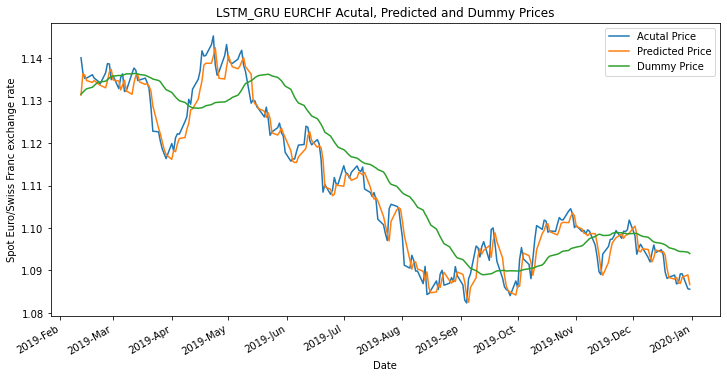

In [25]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

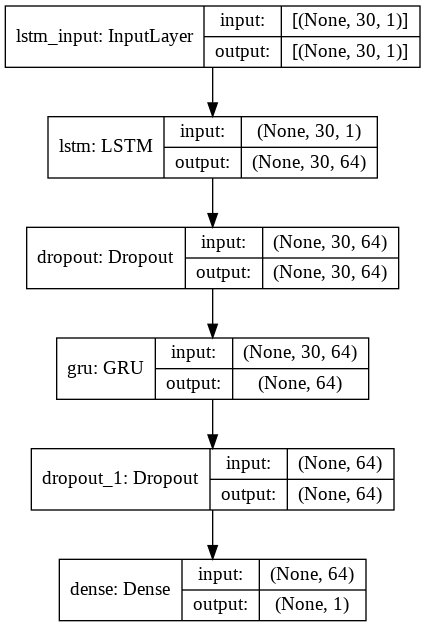

In [26]:
plot_model(model, show_shapes=True, expand_nested=True)

In [27]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0020697743420101775
RMSE:  0.0454947726888505
MAE:  0.03556056748013809
Dummy MSE:  0.01696823190684472
Dummy RMSE:  0.13026216606077423
Dummy MAE:  0.10864031818078547


In [28]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_GRU_EURCHF/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_GRU_EURCHF/assets
